In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
import preprof               ## my functions!

# LinearSVC tfidf
## imports & setup

In [2]:
tfidf_matrix=pickle.load(open('tfidf_matrix', 'rb'))

csv = '/Users/cdw/Desktop/pkpd_script/MNCA_ANALYSIS/ready_processed_2.csv'
papers=pd.read_csv(csv)
relevant = ['Non-compartmental','Modelling']
relevant_papers = papers.loc[papers['category'].isin(relevant)]
y = relevant_papers.loc[:,'category']

tfidf_nofeats=pickle.load(open('tfidf_nofeats','rb'))
tfidf_nofeats=pd.DataFrame(tfidf_nofeats.toarray())

x_train,x_test,y_train,y_test=train_test_split(tfidf_nofeats,y,test_size=0.15,random_state=61097,stratify=y)

In [3]:
tfidf_nofeats.shape

(682, 13772)

In [4]:
###tfidf_nofeats=tfidf_nofeats.drop(columns=11)

In [5]:
preprof.print_proportions(y_train,y_test)

TRAINING
 Modelling            64.939551
Non-compartmental    35.060449
Name: category, dtype: float64

TESTING
 Modelling            65.048544
Non-compartmental    34.951456
Name: category, dtype: float64


In [6]:
model=LinearSVC(random_state=61097).fit(x_train,y_train)
original_pred=model.predict(x_test)

original_acc=accuracy_score(y_test,original_pred)
original_f1=f1_score(y_test,original_pred,pos_label='Non-compartmental')

print('acc: {}'.format(original_acc))
print('f1: {}'.format(original_f1))

acc: 0.8932038834951457
f1: 0.8450704225352113


## feature importance plotting & identification

In [7]:
y_impts = model.coef_
y_impts_sind = np.argsort(y_impts).reshape(13772,1).tolist()
y_impts_sind = [int(x[0]) for x in y_impts_sind]
x_feats = list(tfidf_matrix)
xy = list(zip(y_impts_sind,x_feats))
x_final = [x for _, x in sorted(xy)]

y_impts = sorted([float(x) for x in np.nditer(y_impts)])

In [8]:
## nparray of numerical importances, with dropped weird column
imp=[abs(x) for x in model.coef_]
feat_importance=np.array(imp)

## list of feature names in order
feature_names=list(tfidf_matrix)

In [9]:
##returns index values for the num_feats highest values

def max_ind(array,num_feats):
    inds = array.argsort()
    inds = inds.reshape(inds.shape[1],1)
    inds = inds[-num_feats:][::-1]
    aa=[int(x) for x in inds]
    return aa

In [10]:
## prints top n features
def top_n_feats(feature_names,feat_importance,n):
    top = []
    for x in max_ind(feat_importance,n):
        top.append(feature_names[x])
    return top

In [11]:
top_30=top_n_feats(feature_names,feat_importance,20)
for x in top_30:
    print(x)

model
metabol
formul
popul
cyp3a4
ketoconazol
clearanc
amoxicillin
inhibitor
im
rifampin
rat
dose
decreas
bioequival
p
increas
rtx
chicken
edd


## feature selection

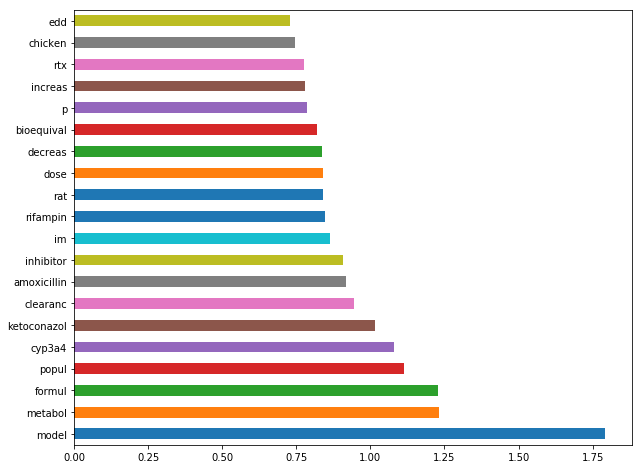

In [12]:
data=pd.Series(abs(model.coef_[0]), index=list(tfidf_matrix)).nlargest(20)
fig=data.plot(kind='barh',figsize=(10,8))
fig.figure.savefig('top_svm.png')

In [13]:
impts = abs(model.coef_[0])
my_dt = pd.DataFrame(impts)
importances = [i[0] for i in my_dt.values.tolist()]

In [14]:
def find(s, c1):
    return [i for i, c2 in enumerate(s) if c2 == c1]

In [15]:
thresh_acc={}
thresholds = np.linspace(0,1,50)

for thresh in thresholds:
    # select features using threshold
    tr_ind = []
    for x in importances:
        if x >= thresh:
            inds=find(importances,x)
            for i in inds:
                tr_ind.append(i)
    tr_ind=list(set(tr_ind))
    select_x_train= x_train.iloc[:,tr_ind]
    if select_x_train.shape[1]==0: continue
    select_x_test = x_test.iloc[:,tr_ind]
    # train model
    selection_model = LinearSVC(max_iter=10000,random_state=61097)
    selection_model.fit(select_x_train, y_train)
    # eval model
    y_pred = selection_model.predict(select_x_test)
    accuracy = accuracy_score(y_test, y_pred)
    thresh_acc[thresh]=accuracy
    print('.',end='')

..................................................

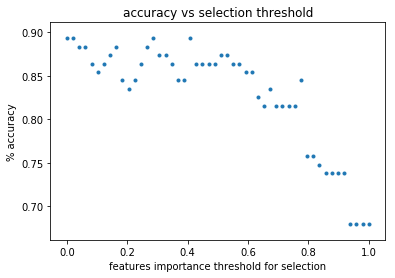

In [16]:
plt.scatter(thresh_acc.keys(),thresh_acc.values(),marker=".")
plt.ylabel('% accuracy')
plt.xlabel('features importance threshold for selection')
plt.title('accuracy vs selection threshold')
plt.savefig('sel_thresholds.png')
plt.show()

<br><br><br><br>

In [17]:
tr_ind = []
for x in importances:
    if x >= 0.33:
        inds=find(importances,x)
        for i in inds:
            tr_ind.append(i)
tr_ind=list(set(tr_ind))

In [18]:
print(len(tr_ind))

320


In [19]:
select_x_train= x_train.iloc[:,tr_ind]
select_x_test = x_test.iloc[:,tr_ind]
# train model
selection_model = LinearSVC(max_iter=10000)
selection_model.fit(select_x_train, y_train)
# eval model
y_pred = selection_model.predict(select_x_test)
accuracy_opt = accuracy_score(y_test, y_pred)
f1_opt = f1_score(y_test,y_pred,pos_label='Non-compartmental')
cr_opt=classification_report(y_test,y_pred)

In [20]:
select_dataset=tfidf_nofeats.iloc[:,tr_ind]
pickle.dump(select_dataset,open('tfidf_nofeats_selected','wb'))

In [21]:
print(accuracy_opt)
print(f1_opt)

0.8737864077669902
0.8219178082191781


In [22]:
print(cr_opt)

                   precision    recall  f1-score   support

        Modelling       0.91      0.90      0.90        67
Non-compartmental       0.81      0.83      0.82        36

        micro avg       0.87      0.87      0.87       103
        macro avg       0.86      0.86      0.86       103
     weighted avg       0.87      0.87      0.87       103

